## About Dataset
Photos of faces expressing different emotions.

Data divided into train(80%), test(10%), and validation(10%) sets in ImageFolder format.

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
num_classes = 7
# Load datasets
train_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/train"),
    image_size=(48, 48),
    batch_size=512
)
validation_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/val"),
    image_size=(48, 48),
    batch_size=256
)
test_dataset = image_dataset_from_directory(
    os.path.join("kuvat/emotions/test"),
    image_size=(48, 48),
    batch_size=256
)

# --- Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Kuvien esikäsittely: skaalataan arvot [0, 1] välille
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255.0, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))


Found 28709 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.
Found 3589 files belonging to 7 classes.


In [63]:
inputs = keras.Input(shape=(48, 48, 3))

x = layers.Conv2D(64, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(256, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 46, 46, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,472,071 (9.43 MB)

 Trainable params: 2,472,071 (9.43 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:

callbacks = [
    EarlyStopping(
        patience=10,
        verbose=0,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    ModelCheckpoint(
        filepath="emotions_CNN.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
test_loss, test_acc = model.evaluate(test_dataset)

# Save results
np.savez("emotions_CNN.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time,
         history=history.history)

Epoch 1/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.2367 - loss: 1.8367
Epoch 1: val_loss improved from inf to 1.71472, saving model to emotions_CNN.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 525ms/step - accuracy: 0.2373 - loss: 1.8356 - val_accuracy: 0.3302 - val_loss: 1.7147
Epoch 2/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.3139 - loss: 1.7208
Epoch 2: val_loss improved from 1.71472 to 1.53201, saving model to emotions_CNN.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 525ms/step - accuracy: 0.3149 - loss: 1.7190 - val_accuracy: 0.4124 - val_loss: 1.5320
Epoch 3/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.4006 - loss: 1.5592
Epoch 3: val_loss improved from 1.53201 to 1.45417, saving model to emotions_CNN.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 551ms/step - accuracy: 0.4010 - loss: 1.5581 - val_accuracy: 0.4508 - val_loss: 1.4542
Epoch 4/20
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.4438 - loss: 1.4585
Epoch 4: val_loss improved from 1.45417 to 1.

In [65]:
test_model = keras.models.load_model(
    "emotions_CNN.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:3f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6021 - loss: 1.0702
Test accuracy: 0.598495


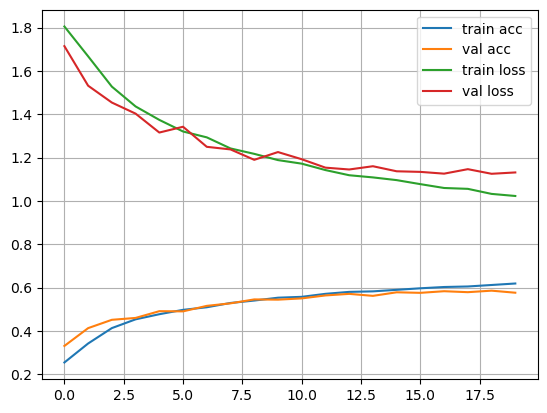

In [66]:
# Assuming you have 'history' from model.fit()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid()
plt.show()

In [67]:

# Separate the images and labels into one numpy array
x_test = []
y_test = []

for images, labels in test_dataset:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

# Combining batches into one large array
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(x_test.shape)
print(y_test.shape)

(3589, 48, 48, 3)
(3589,)


In [68]:
# Ennustetaan kaikki testikuvat
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Alustetaan oikein
class_correct = [0 for _ in range(len(names))]
class_total = [0 for _ in range(len(names))]

# Lasketaan tarkkuus joka luokalle
for true_label, pred_label in zip(y_test, y_pred_labels):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

# Tulostetaan tulokset
for i in range(len(names)):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Accuracy of %5s : %2d %%' % (names[i], accuracy))
    else:
        print('No samples for class', names[i])


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Accuracy of Angry : 59 %
Accuracy of Disgust : 14 %
Accuracy of  Fear : 32 %
Accuracy of Happy : 81 %
Accuracy of   Sad : 37 %
Accuracy of Surprise : 78 %
Accuracy of Neutral : 66 %


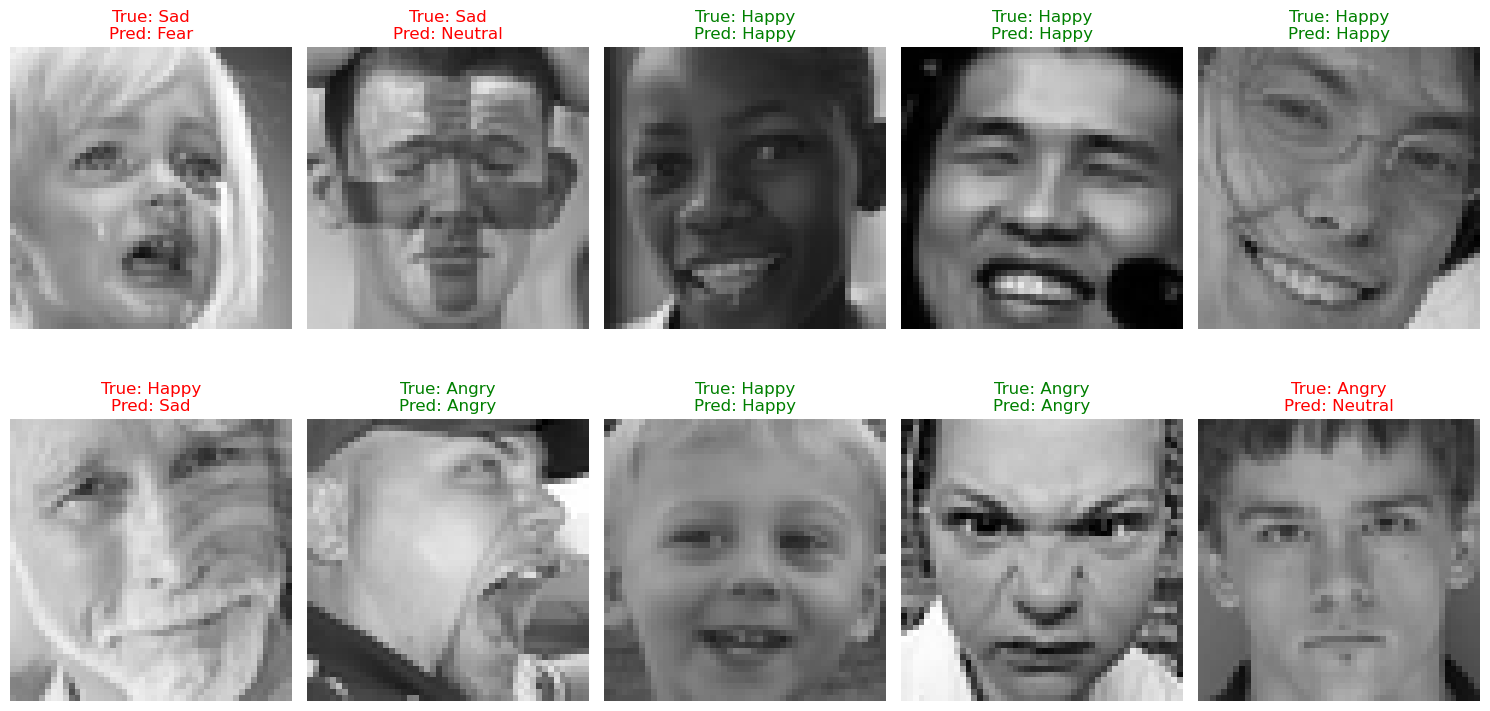

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize a few test images with true and predicted labels
def visualize_predictions(start=0, num_images=10):
    plt.figure(figsize=(15, 8))

    for i in range(num_images):
        plt.subplot(2, 5, i+1)  # 2 rows, 5 images per row
        img = x_test[start + i]
        img = np.clip(img, 0.0, 1.0)  # Ensure values are between 0 and 1
        plt.imshow(img)  # Display the image
        plt.axis('off')

        true_label = names[y_test[start + i]]  # True label
        pred_label = names[y_pred_labels[start + i]]  # Predicted label

        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

    plt.tight_layout()
    plt.show()

# Visualize first 10 images from the test set
visualize_predictions(start=0, num_images=10)

In [70]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score for each class
class_f1_scores = {}
for i, class_name in enumerate(names):
    true_class_indices = (y_test == i)
    pred_class_indices = (y_pred_labels == i)

    precision = precision_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred_labels, labels=[i], average='macro', zero_division=0)

    class_f1_scores[class_name] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Print header
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 40)

# Each class's scores
for class_name, scores in class_f1_scores.items():
    print(f"{class_name:<10} {scores['precision']:<10.2f} {scores['recall']:<10.2f} {scores['f1_score']:<10.2f}")

Class      Precision  Recall     F1 Score  
----------------------------------------
Angry      0.47       0.59       0.52      
Disgust    0.57       0.15       0.23      
Fear       0.43       0.32       0.37      
Happy      0.83       0.82       0.82      
Sad        0.46       0.37       0.41      
Surprise   0.68       0.78       0.73      
Neutral    0.56       0.66       0.61      
